# Sepsis Challenge 2019 — Feature Engineering & Model

Este cuaderno construye una **Baseline** para el *PhysioNet/Computing in Cardiology Sepsis Challenge 2019* utilizando los archivos Parquet obtenidos:

- `all_patients_setA.parquet`  
- `all_patients_setB.parquet`  

## Pasos realizados
1. **Carga de datos y verificaciones básicas**  
2. **Preprocesamiento de series de tiempo a nivel de paciente**  
3. **Ingeniería de características simple (relleno hacia adelante, medias móviles, deltas)**  
4. **División de entrenamiento/validación por paciente**  
5. **Clasificador base (Regresión Logística / HistGradientBoosting)**  
6. **Evaluación (AUROC, Precisión Promedio)**  
7. **Persistencia del modelo**  

> **Nota:** Este es un punto de partida. Para obtener un rendimiento competitivo necesitarás una definición cuidadosa de las etiquetas alrededor del momento de inicio, validación cruzada por paciente, umbrales calibrados y, potencialmente, modelos secuenciales.

In [1]:

import os
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from joblib import dump


## Archivos .parquet del proyecto Sepsis

In [2]:
DATA_DIR = Path("../data/raw")
FILE_A = DATA_DIR / "all_patients_setA.parquet"
FILE_B = DATA_DIR / "all_patients_setB.parquet"
assert FILE_A.exists(), f"Missing {FILE_A.resolve()}"
assert FILE_B.exists(), f"Missing {FILE_B.resolve()}"

print("Found files:")
print(FILE_A.resolve())
print(FILE_B.resolve())

Found files:
/Users/danielayala/Documents/Daniel Ayala/Study/MaIA/DesarrolloSoluciones/Microproyecto/physionet-sepsis-forecasting/data/raw/all_patients_setA.parquet
/Users/danielayala/Documents/Daniel Ayala/Study/MaIA/DesarrolloSoluciones/Microproyecto/physionet-sepsis-forecasting/data/raw/all_patients_setB.parquet


## Carga de datos

In [3]:
df_a = pd.read_parquet(FILE_A)
df_b = pd.read_parquet(FILE_B)
df = pd.concat([df_a, df_b], ignore_index=True)

print(df.shape)
df.head()

(1552210, 43)


,patient_id,AST,Age,Alkalinephos,BUN,BaseExcess,Bilirubin_direct,Bilirubin_total,Calcium,Chloride,...,SBP,SaO2,SepsisLabel,Temp,TroponinI,Unit1,Unit2,WBC,pH,subHR
0,p000001,NaN,83.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p000001,NaN,83.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p000001,NaN,83.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,122.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p000001,NaN,83.14,NaN,NaN,24.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,7.36,NaN
4,p000001,NaN,83.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,122.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns

Index(['patient_id', 'AST', 'Age', 'Alkalinephos', 'BUN', 'BaseExcess',
       'Bilirubin_direct', 'Bilirubin_total', 'Calcium', 'Chloride',
       'Creatinine', 'DBP', 'EtCO2', 'FiO2', 'Fibrinogen', 'Gender', 'Glucose',
       'HCO3', 'HR', 'Hct', 'Hgb', 'HospAdmTime', 'ICULOS', 'Lactate', 'MAP',
       'Magnesium', 'O2Sat', 'PTT', 'PaCO2', 'Phosphate', 'Platelets',
       'Potassium', 'Resp', 'SBP', 'SaO2', 'SepsisLabel', 'Temp', 'TroponinI',
       'Unit1', 'Unit2', 'WBC', 'pH', 'subHR'],
      dtype='object')

## Identificacion de las columnas

In [5]:
# Columnas completas en el dataset (43 en total)
all_columns = df.columns

# Asignar directamente las columnas clave
patient_col = "patient_id"
time_col    = "ICULOS"         # número de horas en UCI (es la variable de tiempo en este dataset)
label_col   = "SepsisLabel"    # etiqueta binaria

print("Columnas clave definidas ->")
print("Paciente:", patient_col)
print("Tiempo:", time_col)
print("Etiqueta:", label_col)

# Definir las columnas de características (todas menos ID, tiempo y etiqueta)
non_feature_cols = {patient_col, time_col, label_col}
num_cols = [c for c in all_columns if c not in non_feature_cols]

print(f"Total de features numéricas: {len(num_cols)}")
print(num_cols[:20])  # muestra algunas

Columnas clave definidas ->
Paciente: patient_id
Tiempo: ICULOS
Etiqueta: SepsisLabel
Total de features numéricas: 40
['AST', 'Age', 'Alkalinephos', 'BUN', 'BaseExcess', 'Bilirubin_direct', 'Bilirubin_total', 'Calcium', 'Chloride', 'Creatinine', 'DBP', 'EtCO2', 'FiO2', 'Fibrinogen', 'Gender', 'Glucose', 'HCO3', 'HR', 'Hct', 'Hgb']


## Limpieza de datos y organización de los datos

In [6]:
# Ordernar por paciente y tiempo
df = df.sort_values([patient_col, time_col]).reset_index(drop=True)

# Matener variable númericas para el modelo
non_feature_cols = {patient_col, time_col, label_col}
num_cols = [c for c in df.columns if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df[c])]

print("Número de variables númericas:", len(num_cols))
num_cols[:60]

Número de variables númericas: 40


['AST',
 'Age',
 'Alkalinephos',
 'BUN',
 'BaseExcess',
 'Bilirubin_direct',
 'Bilirubin_total',
 'Calcium',
 'Chloride',
 'Creatinine',
 'DBP',
 'EtCO2',
 'FiO2',
 'Fibrinogen',
 'Gender',
 'Glucose',
 'HCO3',
 'HR',
 'Hct',
 'Hgb',
 'HospAdmTime',
 'Lactate',
 'MAP',
 'Magnesium',
 'O2Sat',
 'PTT',
 'PaCO2',
 'Phosphate',
 'Platelets',
 'Potassium',
 'Resp',
 'SBP',
 'SaO2',
 'Temp',
 'TroponinI',
 'Unit1',
 'Unit2',
 'WBC',
 'pH',
 'subHR']

In [7]:
import numpy as np
import pandas as pd


# Orden temporal y copia de trabajo
df = df.sort_values([patient_col, time_col]).reset_index(drop=True).copy()

# Flags de medición (información clínica de "se pidió o no se pidió la prueba")
for c in num_cols:
    df[f"{c}_measured"] = df[c].notna().astype(int)

# Forward-fill por paciente (solo sobre features base)
df[num_cols] = df.groupby(patient_col, group_keys=False)[num_cols].apply(lambda g: g.ffill())

# Conjunto final de columnas de entrada = features + flags
feat_flags = [f"{c}_measured" for c in num_cols]
X_cols = num_cols + feat_flags

# Definir matriz objetivo (binaria 0/1)
df[label_col] = df[label_col].astype(int)


In [8]:
X_cols

['AST',
 'Age',
 'Alkalinephos',
 'BUN',
 'BaseExcess',
 'Bilirubin_direct',
 'Bilirubin_total',
 'Calcium',
 'Chloride',
 'Creatinine',
 'DBP',
 'EtCO2',
 'FiO2',
 'Fibrinogen',
 'Gender',
 'Glucose',
 'HCO3',
 'HR',
 'Hct',
 'Hgb',
 'HospAdmTime',
 'Lactate',
 'MAP',
 'Magnesium',
 'O2Sat',
 'PTT',
 'PaCO2',
 'Phosphate',
 'Platelets',
 'Potassium',
 'Resp',
 'SBP',
 'SaO2',
 'Temp',
 'TroponinI',
 'Unit1',
 'Unit2',
 'WBC',
 'pH',
 'subHR',
 'AST_measured',
 'Age_measured',
 'Alkalinephos_measured',
 'BUN_measured',
 'BaseExcess_measured',
 'Bilirubin_direct_measured',
 'Bilirubin_total_measured',
 'Calcium_measured',
 'Chloride_measured',
 'Creatinine_measured',
 'DBP_measured',
 'EtCO2_measured',
 'FiO2_measured',
 'Fibrinogen_measured',
 'Gender_measured',
 'Glucose_measured',
 'HCO3_measured',
 'HR_measured',
 'Hct_measured',
 'Hgb_measured',
 'HospAdmTime_measured',
 'Lactate_measured',
 'MAP_measured',
 'Magnesium_measured',
 'O2Sat_measured',
 'PTT_measured',
 'PaCO2_measured

In [9]:
nan_summary = (
    df.isna()
      .sum()
      .to_frame("NaN_count")
      .assign(NaN_percent=lambda d: d["NaN_count"] / len(df) * 100)
      .sort_values("NaN_percent", ascending=False)
)

# Mostrar las primeras 20 columnas con más NaN
nan_summary.head(50)

,NaN_count,NaN_percent
subHR,1552185,99.998389
Bilirubin_direct,1479916,95.342512
EtCO2,1421637,91.587929
Fibrinogen,1385887,89.284762
TroponinI,1318553,84.946818
Lactate,1089377,70.182321
SaO2,1083561,69.807629
Bilirubin_total,1083290,69.790170
Alkalinephos,1081750,69.690957
AST,1077247,69.400854


In [10]:
# 1. Eliminar columnas con >90% NaN
#threshold = 0.98
#cols_to_drop = nan_summary[nan_summary["NaN_percent"] > threshold * 100].index.tolist()
#df = df.drop(columns=cols_to_drop)

#print("Columnas eliminadas:", cols_to_drop)

df = df[['patient_id', 'SepsisLabel', 'ICULOS', 'Temp', 'subHR', 'Alkalinephos', 'BaseExcess',
       'Bilirubin_direct', 'Bilirubin_total', 'DBP',  'FiO2',  'Gender',
       'HCO3', 'HR',  'HospAdmTime', 'Lactate', 'Magnesium', 'O2Sat', 'Resp', 'SaO2', 'TroponinI', 'Unit2']]

In [11]:
non_feature_cols = {patient_col, time_col, label_col}
num_cols = [c for c in df.columns if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df[c])]

print("Número de variables númericas:", len(num_cols))
num_cols[:20]

Número de variables númericas: 19


['Temp',
 'subHR',
 'Alkalinephos',
 'BaseExcess',
 'Bilirubin_direct',
 'Bilirubin_total',
 'DBP',
 'FiO2',
 'Gender',
 'HCO3',
 'HR',
 'HospAdmTime',
 'Lactate',
 'Magnesium',
 'O2Sat',
 'Resp',
 'SaO2',
 'TroponinI',
 'Unit2']

## Generación de nuevas caracteristicas

In [12]:
# Rellenar hacia adelante (forward fill) los valores faltantes dentro de cada paciente
# Esto asegura que si falta un valor en una hora, se tome el último valor conocido
df[num_cols] = df.groupby(patient_col, group_keys=False)[num_cols].apply(lambda g: g.ffill())

# Lista de signos vitales más relevantes para generar nuevas características
#likely_vitals = [
#    "HR","O2Sat","Temp","SBP","MAP","DBP","Resp","EtCO2",
#    "Lactate","Hct","Hgb","Platelets","Glucose"
#]
likely_vitals = [ "HR", "O2Sat","Resp", "Temp", "Lactate", "FiO2", "BaseExcess", "HCO3" ]

# Tomar solo los que realmente existan en el dataset
roll_base = [c for c in likely_vitals if c in df.columns]

# Para cada vital seleccionado, crear una nueva variable con el promedio móvil
# de las últimas 3 horas (ventana=3). Esto captura la tendencia reciente.

HOURS_WINDOW = 6
for c in roll_base:
    rname = f"{c}_roll{HOURS_WINDOW}"
    df[rname] = (
        df.groupby(patient_col)[c]
          .transform(lambda s: s.rolling(window=HOURS_WINDOW, min_periods=1).mean())
    )

HOURS_WINDOW = 3
for c in roll_base:
    rname = f"{c}_roll{HOURS_WINDOW}"
    df[rname] = (
        df.groupby(patient_col)[c]
          .transform(lambda s: s.rolling(window=HOURS_WINDOW, min_periods=1).mean())
    )
# Para cada vital seleccionado, crear una nueva variable con el delta (diferencia)
# entre la hora actual y la hora anterior. Esto mide cambios bruscos.
for c in roll_base:
    dname = f"{c}_delta"
    df[dname] = df.groupby(patient_col)[c].diff()

# Actualizar la lista de features numéricas:
# incluir todas las columnas numéricas menos ID, tiempo y etiqueta
num_cols = [
    c for c in df.columns
    if c not in {patient_col, time_col, label_col}
    and pd.api.types.is_numeric_dtype(df[c])
]

# Vista rápida de las primeras filas con las nuevas columnas creadas
df.head()


,patient_id,SepsisLabel,ICULOS,Temp,subHR,Alkalinephos,BaseExcess,Bilirubin_direct,Bilirubin_total,DBP,...,BaseExcess_roll3,HCO3_roll3,HR_delta,O2Sat_delta,Resp_delta,Temp_delta,Lactate_delta,FiO2_delta,BaseExcess_delta,HCO3_delta
0,p000001,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p000001,0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p000001,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-8.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN
3,p000001,0,4.0,NaN,NaN,NaN,24.0,NaN,NaN,NaN,...,24.0,NaN,1.0,-4.0,8.0,NaN,NaN,NaN,NaN,NaN
4,p000001,0,5.0,NaN,NaN,NaN,24.0,NaN,NaN,NaN,...,24.0,NaN,13.0,-6.5,-5.5,NaN,NaN,NaN,0.0,NaN


In [13]:
nan_summary = (
    df.isna()
      .sum()
      .to_frame("NaN_count")
      .assign(NaN_percent=lambda d: d["NaN_count"] / len(df) * 100)
      .sort_values("NaN_percent", ascending=False)
)

# Mostrar las primeras 20 columnas con más NaN
nan_summary.head(20)

,NaN_count,NaN_percent
subHR,1552185,99.998389
Bilirubin_direct,1479916,95.342512
TroponinI,1318553,84.946818
Lactate_delta,1101870,70.987173
Lactate_roll3,1089377,70.182321
Lactate,1089377,70.182321
Lactate_roll6,1089377,70.182321
SaO2,1083561,69.807629
Bilirubin_total,1083290,69.790170
Alkalinephos,1081750,69.690957


In [14]:
# ============================
# Análisis univariante vs objetivo binario (sepsis=1)
# ============================
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif

try:
    from scipy.stats import mannwhitneyu
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# ---- Config ----
y_col = "SepsisLabel"   # o "SepsisLabel"
exclude_cols = {"patient_id", "ICULOS", y_col, "onset_hour", "hrs_to_onset"}
num_cols = [c for c in df.columns
            if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]

# Asegura tipo binario 0/1 en y
y = df[y_col].astype(int).values

rows = []
for feat in num_cols:
    x = df[feat].values
    mask = ~pd.isna(x)
    x_valid = x[mask]
    y_valid = y[mask]

    if len(np.unique(y_valid)) < 2 or x_valid.size < 10:
        # sin variación o muy pocos datos → saltar
        continue

    # AUC univariante (robusto ante escalas)
    try:
        auc = roc_auc_score(y_valid, x_valid)
        # AUC < 0.5 puede invertirse (solo para interpretación), lo dejamos tal cual
    except Exception:
        auc = np.nan

    # Correlación punto-biserial (Pearson con y binaria)
    try:
        corr = np.corrcoef(x_valid, y_valid)[0, 1]
    except Exception:
        corr = np.nan

    # Mutual information (no lineal)
    try:
        mi = mutual_info_classif(x_valid.reshape(-1, 1), y_valid, discrete_features=False, random_state=42)
        mi = float(mi[0])
    except Exception:
        mi = np.nan

    # Mann–Whitney U (distribuciones distintas 0 vs 1)
    if SCIPY_OK:
        try:
            x0 = x_valid[y_valid == 0]
            x1 = x_valid[y_valid == 1]
            if len(x0) > 0 and len(x1) > 0:
                U, p = mannwhitneyu(x0, x1, alternative="two-sided")
            else:
                p = np.nan
        except Exception:
            p = np.nan
    else:
        p = np.nan

    # Cohen's d (tamaño de efecto)
    try:
        x0 = x_valid[y_valid == 0]
        x1 = x_valid[y_valid == 1]
        m0, m1 = np.nanmean(x0), np.nanmean(x1)
        s0, s1 = np.nanstd(x0, ddof=1), np.nanstd(x1, ddof=1)
        n0, n1 = len(x0), len(x1)
        sp = np.sqrt(((n0-1)*(s0**2) + (n1-1)*(s1**2)) / max(n0+n1-2, 1))
        d = (m1 - m0) / sp if sp > 0 else np.nan
    except Exception:
        d = np.nan

    rows.append({
        "feature": feat,
        "auc_univar": auc,
        "corr_pb": corr,
        "mutual_info": mi,
        "p_mannwhitney": p,
        "cohens_d": d,
        "mean_0": np.nanmean(x_valid[y_valid == 0]) if np.any(y_valid == 0) else np.nan,
        "mean_1": np.nanmean(x_valid[y_valid == 1]) if np.any(y_valid == 1) else np.nan,
        "nan_pct": 100.0 * (1.0 - mask.mean())
    })

summary_uni = pd.DataFrame(rows).sort_values(["auc_univar"], ascending=False).reset_index(drop=True)
summary_uni.head(20)


,feature,auc_univar,corr_pb,mutual_info,p_mannwhitney,cohens_d,mean_0,mean_1,nan_pct
0,HR_roll3,0.601717,0.050280,0.003045,0.000000e+00,0.377280,84.284723,90.617869,2.285902
1,HR_roll6,0.600408,0.049161,0.002002,0.000000e+00,0.368862,84.319409,90.397050,2.285902
2,HR,0.600119,0.049874,0.006711,0.000000e+00,0.374225,84.255708,90.746119,2.285902
3,Temp,0.598935,0.051580,0.009069,0.000000e+00,0.385362,36.868362,37.144803,7.420323
4,Temp_roll3,0.598874,0.050239,0.005855,0.000000e+00,0.375317,36.860498,37.123271,7.420323
5,Temp_roll6,0.597004,0.047528,0.004058,0.000000e+00,0.355018,36.850628,37.092353,7.420323
6,Resp_roll6,0.594757,0.049892,0.005184,0.000000e+00,0.374357,18.583025,20.219457,3.069237
7,Resp_roll3,0.589684,0.047380,0.007938,0.000000e+00,0.355462,18.628053,20.263310,3.069237
8,Resp,0.580029,0.041864,0.019070,0.000000e+00,0.314002,18.661519,20.271128,3.069237
9,Bilirubin_direct,0.577445,0.039148,0.013337,1.290820e-43,0.205595,1.438359,2.141034,95.342512


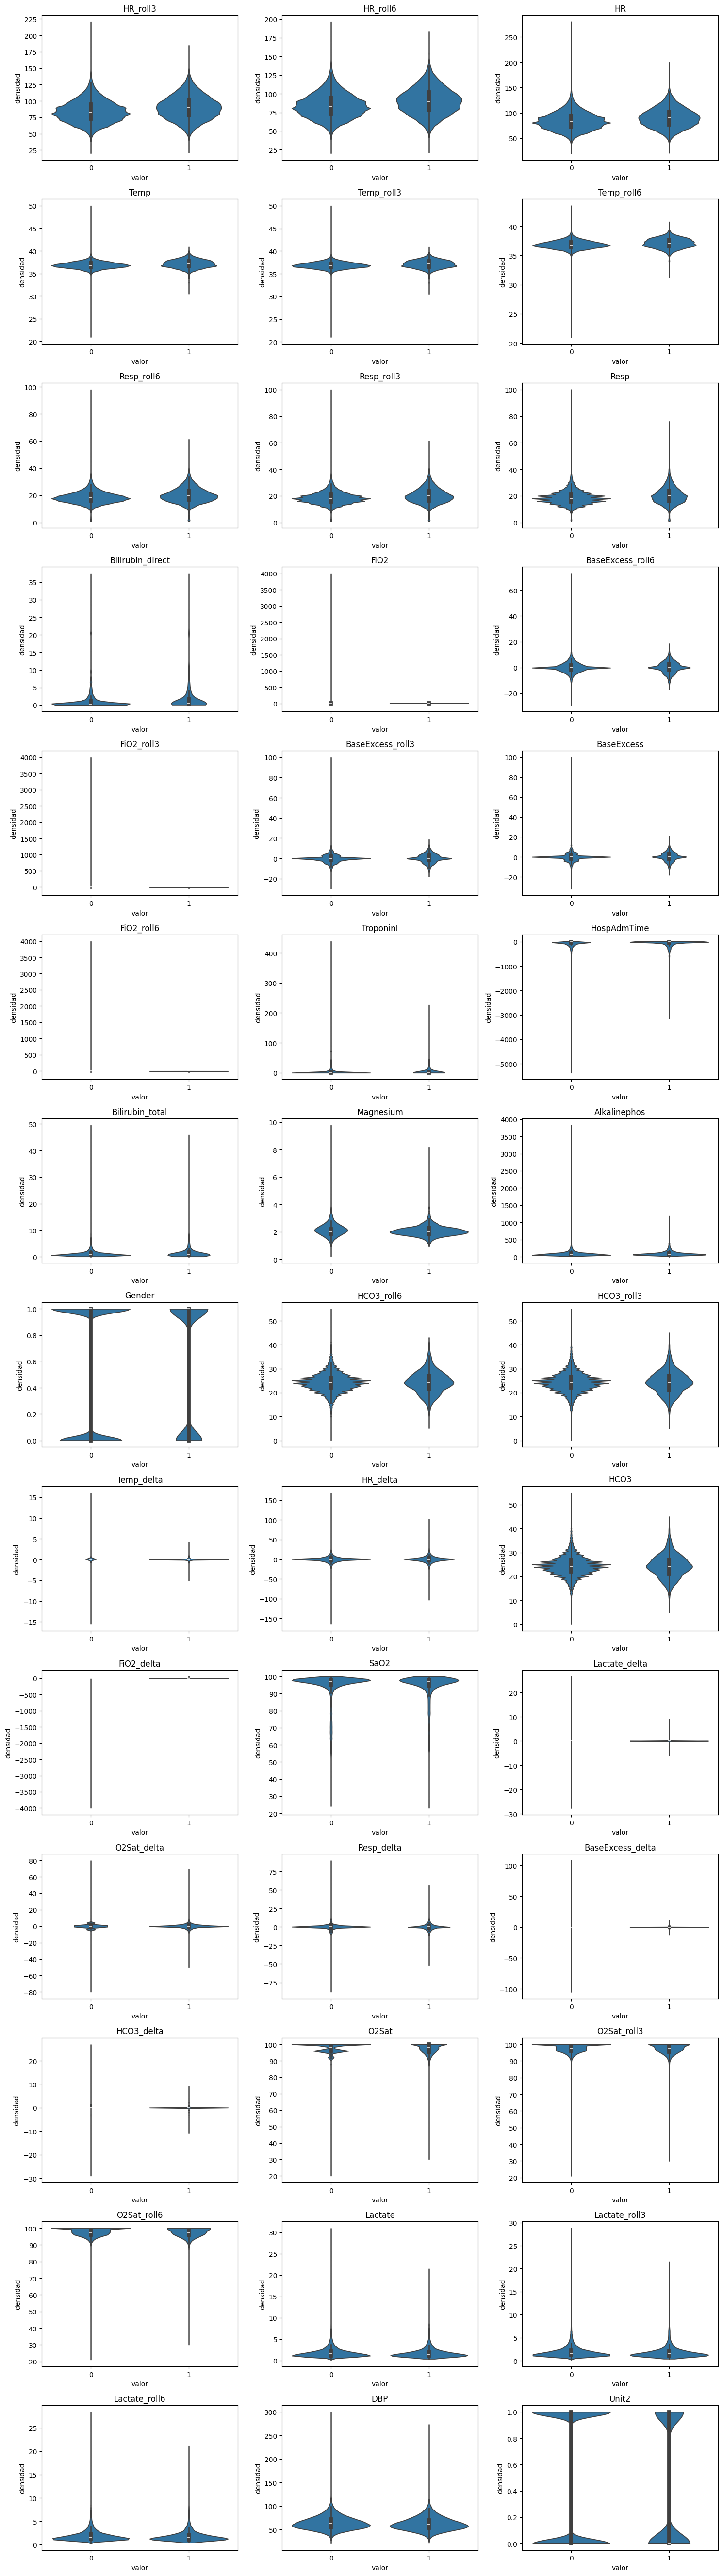

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topk_hist(summary_df, k=10, bins=30):
    top_feats = summary_df["feature"].head(k).tolist()
    n = len(top_feats)
    cols = 3
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(5*cols, 3.8*rows))
    for i, feat in enumerate(top_feats, 1):
        ax = plt.subplot(rows, cols, i)
        vals0 = df.loc[df[y_col] == 0, feat].dropna().values
        vals1 = df.loc[df[y_col] == 1, feat].dropna().values
        #if len(vals0) > 0:
        #    ax.hist(vals0, bins=bins, alpha=0.6, density=True, label="y=0")
        #if len(vals1) > 0:
        #    ax.hist(vals1, bins=bins, alpha=0.6, density=True, label="y=1")
        sns.violinplot(data=df[[feat, y_col]], x=y_col, y=feat, cut=0)
        ax.set_title(f"{feat}")
        ax.set_xlabel("valor"); ax.set_ylabel("densidad")
        #ax.legend()
    plt.tight_layout()
    plt.show()

plot_topk_hist(summary_uni, k=100)


## Train/Validation Split by Patient (Group-wise)

In [16]:
# Usa una división por grupos para que ningún paciente aparezca tanto en entrenamiento como en validación.
groups = df[patient_col].values
X = df[num_cols].values
y = df[label_col].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, valid_idx = next(gss.split(X, y, groups=groups))

X_train, X_valid = X[train_idx], X[valid_idx]
y_train, y_valid = y[train_idx], y[valid_idx]

len_train = len(train_idx)
len_valid = len(valid_idx)
len_train, len_valid

(1241213, 310997)

## Primero Modelo (Logistic Regression)

In [19]:
logreg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),  # sparse safety
    ("pca", PCA(n_components=0.30, random_state=42)),  # ajusta el número de componentes
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", n_jobs=-1))
])

logreg_pipe.fit(X_train, y_train)

pred_proba_lr = logreg_pipe.predict_proba(X_valid)[:, 1]
auroc_lr = roc_auc_score(y_valid, pred_proba_lr)
auprc_lr = average_precision_score(y_valid, pred_proba_lr)

print(f"LogReg AUROC: {auroc_lr:.4f} | AUPRC: {auprc_lr:.4f}")

LogReg AUROC: 0.6388 | AUPRC: 0.0345


## Modelo Alternativo (HistGradientBoostingClassifier)

In [20]:
hgb = HistGradientBoostingClassifier(
    max_depth=None,
    learning_rate=0.05,
    max_iter=1000,
    class_weight="balanced"
)
# Impute only (tree models don't need scaling)
imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_train)
X_valid_imp = imp.transform(X_valid)

hgb.fit(X_train_imp, y_train)
pred_proba_hgb = hgb.predict_proba(X_valid_imp)[:, 1]
auroc_hgb = roc_auc_score(y_valid, pred_proba_hgb)
auprc_hgb = average_precision_score(y_valid, pred_proba_hgb)

print(f"HGB AUROC: {auroc_hgb:.4f} | AUPRC: {auprc_hgb:.4f}")

HGB AUROC: 0.7413 | AUPRC: 0.0646


## Threshold y Reporte

In [21]:
def report_at_threshold(y_true, y_prob, thr=0.5, name="model"):
    y_pred = (y_prob >= thr).astype(int)
    print(f"\n{name} @ threshold={thr:.2f}")
    print(classification_report(y_true, y_pred, digits=3))

report_at_threshold(y_valid, pred_proba_lr, thr=0.5, name="LogReg")
report_at_threshold(y_valid, pred_proba_hgb, thr=0.5, name="HGB")



LogReg @ threshold=0.50
              precision    recall  f1-score   support

           0      0.989     0.645     0.781    305750
           1      0.027     0.567     0.051      5247

    accuracy                          0.644    310997
   macro avg      0.508     0.606     0.416    310997
weighted avg      0.972     0.644     0.768    310997


HGB @ threshold=0.50
              precision    recall  f1-score   support

           0      0.989     0.855     0.917    305750
           1      0.050     0.448     0.091      5247

    accuracy                          0.848    310997
   macro avg      0.520     0.652     0.504    310997
weighted avg      0.973     0.848     0.903    310997



In [ ]:
import matplotlib.pyplot as plt

# Suponiendo que ya tienes:
# y_valid → etiquetas verdaderas
# pred_proba_lr  → probabilidades predichas por Logistic Regression
# pred_proba_hgb → probabilidades predichas por HistGradientBoosting

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# -------- LogReg --------
probas_pos_lr = pred_proba_lr[y_valid == 1]
probas_neg_lr = pred_proba_lr[y_valid == 0]

axes[0].hist(probas_neg_lr, bins=30, alpha=0.6, label="Clase 0 (No Sepsis)", color="steelblue", density=True)
axes[0].hist(probas_pos_lr, bins=30, alpha=0.6, label="Clase 1 (Sepsis)", color="indianred", density=True)
axes[0].axvline(0.95, color="black", linestyle="--", label="thr=0.9")
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Probabilidad predicha")
axes[0].set_ylabel("Densidad")
axes[0].legend()

# -------- HGB --------
probas_pos_hgb = pred_proba_hgb[y_valid == 1]
probas_neg_hgb = pred_proba_hgb[y_valid == 0]

axes[1].hist(probas_neg_hgb, bins=30, alpha=0.6, label="Clase 0 (No Sepsis)", color="steelblue", density=True)
axes[1].hist(probas_pos_hgb, bins=30, alpha=0.6, label="Clase 1 (Sepsis)", color="indianred", density=True)
axes[1].axvline(0.95, color="black", linestyle="--", label="thr=0.9")
axes[1].set_title("HistGradientBoosting")
axes[1].set_xlabel("Probabilidad predicha")
axes[1].legend()

plt.suptitle("Distribución de probabilidades predichas por clase real", fontsize=16)
plt.tight_layout()
plt.show()


## Save Models

In [ ]:
Path("models").mkdir(exist_ok=True)
dump(logreg_pipe, f"../models/logreg_baseline_window_{HOURS_WINDOW}_2.joblib")
dump({"imputer": imp, "model": hgb}, f"../models/hgb_baseline_{HOURS_WINDOW}_2.joblib")
print("Saved models to ../models/")
